In [4]:
# coding: utf-8
#from __future__ import print_function
import pandas as pd
from datetime import datetime
import numpy as np
import csv
from PIL import Image, ImageDraw, ImageFont
import sys
import math
import matplotlib.pyplot as plt

__version__ = "1.03"

In [150]:
class SaikyoABC(object):
    u"""西京中学プロジェクト：答案データ(Answer Box Creater)処理用クラス
    
    SaikyoABC(ファイル名)で、ファイル名で指定したCSVファイルを読み込んだインスタンスを生成します。
    
    -------
    - start_time : 回答開始時刻
    - end_time : 回答終了時刻
    - stroke : ストロークデータ（pandasのDataFrame）
        - stroke.PENTYPE : ペンタイプ（STYLUS, ERASEPEN, NAMEのいずれか）
        - stroke.PENWIDTH : ペンの太さ（int型)
        - stroke.Timestamp : そのストロークが書き始められた時刻
        - stroke.STROKE : np.arrayで与えられるストローク座標データ
        
    以下で出力されるインスタンス変数、メソッドの内、以降のデータ解析に用いられるものについては
    Compare_answersの中で説明しているのでそちらを参照してください。
    """
        
    def __init__(self,filename=None):
        if filename is not None:
            self.read_stroke_csv(filename)
    
    
    def read_stroke_csv(self, filename):
        u"""ストロークが入ったCSVファイルを読み込む。
        -----
        input:
            filename: ファイル名（strokes.csv）
        """
        self.filename = filename
        self.true_or_false = 1
        u"""filenameの答案が正解しているなら２三角なら１間違いなら０"""
        
        # ストロークが入ったCSVファイルを読み込みます．ただし，最初の行と最後の行は読み込みません．
        df = pd.read_csv(filename,header=None,skiprows=1,skipfooter=1,engine='python')
        df.columns = ["Date","Time","MODE","PEN","UNKNOWN","STROKE","STROKE_NUM"]
        # 時刻情報をpythonのdatetimeオブジェクトに変換します．（そうすると時刻の引き算が簡単になるので）
        df = df.assign(Timestamp = [datetime.strptime(row.Date+" "+row.Time, "%Y/%m/%d %H:%M:%S.%f") for row in df.itertuples()] )
        
        # ペンの色とかはどうでもいいので，ペンタイプ（スタイラス or 消しゴム）とペン（もしくは消しゴム）の太さの情報のみを残します．
        df = df.assign(PENTYPE = [d.split()[0] for d in df.PEN])
        penwidth = [d.split()[2] for d in df.PEN]
        df = df.assign(PENWIDTH = [int(d.split(";")[0]) for d in penwidth])
        
        
        # ストロークデータをnumpyの2次元配列に変換．
        stroke = [d.split() for d in df.STROKE]
        def toNumpy(stroke):
            return np.array([s.split(":") for s in stroke],dtype=np.int).T
        df.STROKE = [toNumpy(s) for s in stroke]
 
        
        # ストロークの座標が-1になっているやつは，名前欄に記入したストロークなので，ペンタイプをNAMEにしておく．
        df.loc[ [np.min(s)<0 for s in df.STROKE], "PENTYPE" ] = "NAME"

        # 不要な列を削除
        del df['Date']
        del df['Time']
        del df['MODE']
        del df['UNKNOWN']
        del df['PEN']
        del df['STROKE_NUM']
        
        self.stroke = df
        u"""
        #csvファイルを標準出力
        print(df.columns)
        df.to_csv(sys.stdout)
        """
        
        # 解答開始時刻（csvファイルの1行目）と終了時刻（csvファイルの最終行)を計算する．
        f = open(filename,'r')
        dataReader = csv.reader(f)
        
        u"""
        first = dataReader.next()
        #下に変更したので注意！！
        """
        
        #ヘッダーを読み飛ばす
        first = next(dataReader)  
        
        for last in dataReader:
            ("")
        
        
        f.close()
        self.start_time = datetime.strptime(first[0]+" "+first[1], "%Y/%m/%d %H:%M:%S.%f")
        self.end_time = datetime.strptime(last[0]+" "+last[1], "%Y/%m/%d %H:%M:%S.%f")
        
        
    def draw_image(self,image_size=None):
        u"""ストロークデータを画像として出力する。
        -----
        input
            - image_size: 画像サイズ。(幅,高さ)で指定してください。※numpyの行列とは順番が逆なので注意！！
        """
        if image_size is None:
            image_size = np.max(np.array([np.max(s,axis=1) for s in data.stroke.STROKE]),axis=0)
        image = Image.new("RGBA",image_size,color=(255,255,255,0))
        self.__draw_image(image)
        return image
    
    
    def overlay_image(self,originalimage):
        u"""元の画像にオーバーレイする形で描画する"""
        
        background = originalimage.copy()
        background = background.convert("RGBA")
        foreground = self.draw_image(background.size)
        background.paste(foreground,(0,0),foreground)
        return background
    
    
    def __draw_image(self,image):
        draw = ImageDraw.Draw(image)
        for s,p,w in zip(self.stroke.STROKE,self.stroke.PENTYPE,self.stroke.PENWIDTH):
            if p == "STYLUS":
                draw.line(tuple(s.T.flatten()),fill=(255,0,0,128),width=w*1)
            elif p == "ERASEPEN":
                draw.line(tuple(s.T.flatten()),fill=(128,128,0,128),width=w*10)
    
    
    
    def draw_block_image(self,image_size=None):
        u"""ブロックのまとまりを画像として出力する。
        -----
        input
            - image_size: 画像サイズ。(幅,高さ)で指定してください。※numpyの行列とは順番が逆なので注意！！
        """
        if image_size is None:
            image_size = np.max(np.array([np.max(s,axis=1) for s in data.stroke.STROKE]),axis=0)
        image = Image.new("RGBA",image_size,color=(255,255,255,0))
        self.__draw_block_image(image)
        return image
    
    
    def overlay_block_image(self,originalimage):
        u"""元の画像にオーバーレイする形で描画する"""
        
        background = originalimage.copy()
        background = background.convert("RGBA")
        foreground = self.draw_block_image(background.size)
        background.paste(foreground,(0,0),foreground)
        return background
    

        
    def __draw_block_image(self,image):
        u"""
        ブロックのスケールを画像にプロットします
        """
        draw = ImageDraw.Draw(image)
        X = 0
        Y = 1
        xmin = 0
        xmax = 1
        ymin = 2
        ymax = 3
        font = ImageFont.truetype("arial.ttf", 32)
        for block_num in range(len(self.block_range)):
            X_xmin = self.block_range[block_num][X][xmin]
            Y_ymax = self.block_range[block_num][Y][ymax]
            X_xmax = self.block_range[block_num][X][xmax]
            Y_ymin = self.block_range[block_num][Y][ymin]
            draw.rectangle(((X_xmin,Y_ymax),(X_xmax,Y_ymin)),fill=(255,255,255,10),outline=(0,0,0))
            draw.text((X_xmin,Y_ymax), str(block_num) ,fill='#000',font = font)
                
                
    def __get_time_lag(self):
        u"""
        各ストローク間の時間差をnumpyに変換します。
        ペンストロークの始点から次の始点の始まりまでの時間間隔です。
        [time_lag_1,time_lag_2,time_lag_3,....]で返します。
        要素数が１つ減っているので注意。
        """
        time_lag = np.array([self.stroke.Timestamp[i+1]-self.stroke.Timestamp[i] 
                             for i in range(len(self.stroke.Timestamp) - 1)])
        return time_lag
    
    
    def __get_stroke_center(self):
        u"""
        各ストロークの中心点を定めます。
        [[Xcenter1,Ycenter1],[Xcenter2,...],....]
        の形になります。
        """
        stroke_center = np.array([[self.stroke.STROKE[stroke_num][0].mean(),self.stroke.STROKE[stroke_num][1].mean()]
                                  for stroke_num in range(len(self.stroke.STROKE))])
        return stroke_center

    
    def __get_stroke_range(self):
        u"""
        各ストロークのx座標、y座標それぞれの範囲をnumpyで返します。
        [[[x_xmin,x_xmax,x_ymin,x_ymax],[y_xmin,y_xmax,y_ymin,y_ymax]],
         [],......]
         を返します。
         stroke.range[stroke_num][XorY][(0:xmin〜3:ymaxの数字で選べます)]
        """
        X=0
        Y=1
        stroke_range = np.array([[[self.stroke.STROKE[stroke_num][X][np.argmin(self.stroke.STROKE[stroke_num][X])],
                                   self.stroke.STROKE[stroke_num][X][np.argmax(self.stroke.STROKE[stroke_num][X])],
                                   self.stroke.STROKE[stroke_num][X][np.argmin(self.stroke.STROKE[stroke_num][Y])],
                                   self.stroke.STROKE[stroke_num][X][np.argmax(self.stroke.STROKE[stroke_num][Y])]],
                                  [self.stroke.STROKE[stroke_num][Y][np.argmin(self.stroke.STROKE[stroke_num][X])],
                                   self.stroke.STROKE[stroke_num][Y][np.argmax(self.stroke.STROKE[stroke_num][X])],
                                   self.stroke.STROKE[stroke_num][Y][np.argmin(self.stroke.STROKE[stroke_num][Y])],
                                   self.stroke.STROKE[stroke_num][Y][np.argmax(self.stroke.STROKE[stroke_num][Y])]]]
                                 for stroke_num in range(len(self.stroke))])
        return stroke_range
        
    
    def __get_stroke_distance(self):
        u"""
        各ストロークの終点と次の始点までの距離を返します。
        [stroke_distance_1,stroke_distance_2,.....]で返します。
        要素数が１つ減っているので注意。
        """
        stroke_distance = np.array([math.sqrt((self.stroke.STROKE[i][0][0] - self.stroke.STROKE[i+1][0][-1])**2
                                    + (self.stroke.STROKE[i][1][0] - self.stroke.STROKE[i+1][0][-1])**2)
                                    for i in range(len(self.stroke.STROKE) - 1)])
        return stroke_distance
    
            
    def __get_block_average_length(self,block_num,stroke_num):
        u"""
        特定のブロックに含まれるストロークの平均の長さを返します
        [len1,len2,....]
        の形です。
        """
        block_average_length = (self.block_average_length[block_num] + strokeLength(self.stroke.STROKE[stroke_num])) / (len(self.blocks[block_num]) + 1)
        return block_average_length
    
        
    def __get_compared_range(self,block_num,stroke_num):
        u"""
        現在見ているstrokeとそのstrokeを加えるblockのスケールを比較し、blockのスケールを更新します。
        self.block_range内に格納されます。形はstroke_classifierで説明しています。
        その後、block_numのblockのrangeを返します。
        """
        X = 0
        Y = 1
        xmin = 0
        xmax = 1
        ymin = 2
        ymax = 3
        if self.block_range[block_num][X][xmin] > self.stroke_range[stroke_num][X][xmin]:
            self.block_range[block_num][X][xmin] = self.stroke_range[stroke_num][X][xmin]
            self.block_range[block_num][Y][xmin] = self.stroke_range[stroke_num][Y][xmin]
        if self.block_range[block_num][X][xmax] < self.stroke_range[stroke_num][X][xmax]:
            self.block_range[block_num][X][xmax] = self.stroke_range[stroke_num][X][xmax]
            self.block_range[block_num][Y][xmax] = self.stroke_range[stroke_num][Y][xmax]
        if self.block_range[block_num][Y][ymin] > self.stroke_range[stroke_num][Y][ymin]:
            self.block_range[block_num][X][ymin] = self.stroke_range[stroke_num][X][ymin]
            self.block_range[block_num][Y][ymin] = self.stroke_range[stroke_num][Y][ymin]
        if self.block_range[block_num][Y][ymax] < self.stroke_range[stroke_num][Y][ymax]:
            self.block_range[block_num][X][ymax] = self.stroke_range[stroke_num][X][ymax]
            self.block_range[block_num][Y][ymax] = self.stroke_range[stroke_num][Y][ymax]
        """    
        elif self.block_range[block_num][X][xmin] == self.stroke_range[stroke_num][XY][xmin]:
            if self.block_range[block_num][X][ymax] < self.stroke_range[stroke_num][Y][ymax]:
                self.block_range[block_num][Y][ymax] = self.stroke_range[stroke_num][Y][ymax]
            elif self.block_range[block_num][Y][ymin] > self.stroke_range[stroke_num][Y][ymin]:
                self.block_range[block_num][Y][ymin] = self.stroke_range[stroke_num][Y][ymin]
        elif self.block_range[block_num][X][xmax] == self.stroke_range[stroke_num][X][xmax]:
            if self.block_range[block_num][X][ymax] < self.stroke_range[stroke_num][Y][ymax]:
                self.block_range[block_num][Y][ymax] = self.stroke_range[stroke_num][Y][ymax]
            elif self.block_range[block_num][Y][ymin] > self.stroke_range[stroke_num][Y][ymin]:
                self.block_range[block_num][Y][ymin] = self.stroke_range[stroke_num][Y][ymin]
        elif self.block_range[block_num][X][xmin] == self.stroke_range[stroke_num][XY][xmin]:
            if self.block_range[block_num][X][ymax] < self.stroke_range[stroke_num][Y][ymax]:
                self.block_range[block_num][Y][ymax] = self.stroke_range[stroke_num][Y][ymax]
            elif self.block_range[block_num][Y][ymin] > self.stroke_range[stroke_num][Y][ymin]:
                self.block_range[block_num][Y][ymin] = self.stroke_range[stroke_num][Y][ymin]
        elif self.block_range[block_num][X][xmin] == self.stroke_range[stroke_num][XY][xmin]:
            if self.block_range[block_num][X][ymax] < self.stroke_range[stroke_num][Y][ymax]:
                self.block_range[block_num][Y][ymax] = self.stroke_range[stroke_num][Y][ymax]
            elif self.block_range[block_num][Y][ymin] > self.stroke_range[stroke_num][Y][ymin]:
                self.block_range[block_num][Y][ymin] = self.stroke_range[stroke_num][Y][ymin]
        """
        
        return self.block_range[block_num]
    
    
    def __get_block_center(self,block_num,stroke_num):
        u"""ストロークのブロックの中心点を得ます。
        [[block1_X,block1_Y],[block2_X,...],...]
        の形で出力します。
        """
        X = 0 
        Y = 1
        self.block_center[block_num][X] = (self.block_center[block_num][X] * len(self.blocks[block_num]) + self.stroke_center[stroke_num][X]) / (len(self.blocks[block_num]) + 1)
        self.block_center[block_num][Y] = (self.block_center[block_num][Y] * len(self.blocks[block_num]) + self.stroke_center[stroke_num][Y]) / (len(self.blocks[block_num]) + 1)        
        return self.block_center[block_num]
    
    
    def __check_included(self,block_num,stroke_num):
        u"""
        stroke_numのストロークがblock_numのブロックに含まれるかを判定する関数です。
        含まれるなら１を、含まれないなら０を返します。
        """
        distance = 0
        u"""
        stroke_numのstrokeがblock_numのブロックに含まれるかを判定する評価尺度。
        大きいほどblock_numのブロックに含まれる可能性が小さくなります。
        """
        threshhold = 25
        u"""閾値"""
        
        X = 0
        Y = 1
        
        w_time_lag = 1/2
        w_stroke_range = 1
        w_stroke_length = 1/100
        w_stroke_distance = 1/1000
        w_block_range = 1
        w_block_average_length = 1
        w_length_compare = 1/5
        w_distance_stroke_block = 1/4
        
        average_stroke_distance = 0
        for avenum in self.blocks[block_num]:
            average_stroke_distance += self.stroke_distance[avenum]
        average_stroke_distance /= len(self.blocks[block_num])
        
        time_lag = self.time_lag[stroke_num - 1]
        u"""ストロークが引かれるまでの時間間隔"""
        if time_lag.days >= 1:
            time_lag = 5
        else:
            time_lag = time_lag.seconds + time_lag.microseconds / (10**6)
           
        distance_stroke_block = math.sqrt((self.block_center[block_num][X] - self.stroke_center[stroke_num][X])**2 
                                          + (self.block_center[block_num][Y] - self.stroke_center[stroke_num][Y])**2)
        u"""ブロックとストロークとの距離"""
        length_compare = math.sqrt((strokeLength(self.stroke.STROKE[stroke_num]) - self.block_average_length[block_num])**2)
        u"""ストロークの平均の長さとの差"""
        block_size = (self.block_range[block_num][X][1] - self.block_range[block_num][X][0])*(self.block_range[block_num][Y][3] - self.block_range[block_num][Y][2])
        d1 = (w_time_lag * time_lag * w_stroke_distance * self.stroke_distance[stroke_num - 1])
        d2 = (w_distance_stroke_block * distance_stroke_block) * (1/2 +  1/block_size)
        d3 = (w_length_compare * length_compare)
        d4 = (w_stroke_length * strokeLength(self.stroke.STROKE[stroke_num]))
        distance = d1 + d2 + d3 + d4
        """
        print("---------------------------------------------------------------------------------")
        print(self.time_lag[stroke_num - 1])
        print('timelag:{0}'.format(time_lag))
        print('distance_stroke_block:{0}'.format(distance_stroke_block))
        print('block_size:{0}'.format(block_size))
        print('length_compare:{0}'.format(length_compare))
        print('distance:{0}'.format(distance))
        print('AverageStrokeDistance:{0}'.format(average_stroke_distance))
        print(d1)
        print(d2)
        print(d3)
        print(d4)
       """
        if distance < threshhold:
            return 1
        else:
            return 0                                       

        
        
    def stroke_classifier(self):
        u"""
        各ストロークをストロークのクラスタblocksに分類していく関数です。
        self.stroke.STROKE[stroke_num]でが取り出せる。
        """
        X = 0
        Y = 1
        xmin = 0
        xmax = 1
        ymin = 2
        ymax = 3
        self.time_lag = self.__get_time_lag()
        self.stroke_range = self.__get_stroke_range()
        self.stroke_distance = self.__get_stroke_distance()
        self.stroke_center = self.__get_stroke_center()
        self.blocks = [[]]
        u"""
        blocks:[[stroke_num1,stroke_num2,...],[stroke_numA,stroke_numB,...],...]
        の形になっています。
        """
        self.block_range = [[]]
        u"""
        block_range:[[[x_xmin_block1,x_xmax_block1,x_ymin_block1,x_ymax_block1],[y_xmin_block1,...]],
                     [[],[]],...]
                     の形になっています。
        block_range[block_num][XorY][select(min_or_max)of(XorY)(要素の順番は上記の通り)]
        """
        self.block_center = [0]
        u"""
        各ブロックの中心点を定めます。
        [[Xcenter1,Ycenter1],[Xcenter2,...],...]
        の形です。
        """
        self.block_average_length = [0]
        block_num = 0
        
        for stroke_num in range(len(self.stroke)) :
            if self.stroke.STROKE[stroke_num][0][0] == -1:
                pass
            elif len(self.blocks[block_num]) == 0 :
                u"""
                ブロックが空の時は、現在のブロックに対する評価が出来ないため念のため最初の処理は分けています。
                """
                self.blocks = [[stroke_num]]
                self.block_range = [self.stroke_range[stroke_num]]
                self.block_average_length[0] = strokeLength(self.stroke.STROKE[stroke_num])
                self.block_center[0] = self.stroke_center[stroke_num]
            else:
                if self.__check_included(block_num,stroke_num) == 0:
                    u"""現在のブロックにストロークを含めない場合"""
                    self.blocks.append([stroke_num])
                    self.block_range.append(self.stroke_range[stroke_num])
                    self.block_average_length.append(strokeLength(self.stroke.STROKE[stroke_num]))
                    self.block_center.append(self.stroke_center[stroke_num])
                    block_num += 1
                else:
                    u"""現在のブロックに新しいストロークを追加する場合"""
                    self.blocks[block_num].append(stroke_num) 
                    self.block_range[block_num] = self.__get_compared_range(block_num,stroke_num)
                    self.block_average_length[block_num] = self.__get_block_average_length(block_num,stroke_num)
                    self.block_center[block_num] = self.__get_block_center(block_num,stroke_num)
    
    
    u"""
    ----------------------------------------------------------------------------------------------------
    ここから各ブロックの対応関係をわかりやすくするため、ブロックに分割されたペンストロークの特徴量をさらに取り出すプログラムです。
    ----------------------------------------------------------------------------------------------------
    """
    
    
    def __check_stroke_or_string(self,underline):
        u"""そのブロックが補助線か計算式かを判断します。
        self.stroke_or_string[block_num]に
        補助線 → 0
        計算式 → 1
        を格納します。"""
        self.stroke_or_string = [0] * len(self.blocks)
        for block_num in range(len(self.blocks)):
            if self.block_range[block_num][1][3] > underline:
                u"""純粋にブロックのy座標が大きければ計算式としています。これは解答欄が下の方にあることに依っています。
                問題ごとに解答欄の位置が異なるので、underlineの値を調整する必要があります。"""
                self.stroke_or_string[block_num] = 1
    
    def __get_stroke_vector(self):
        
        u"""
        ストロークの点の連続をベクトル化します。
        [[x_vec1,y_vec1],[x_vec2,y_vec2],...],....]
        の形です。
        stroke_vector[stroke_num][vector_num]
        """
        X=0
        Y=1
        self.stroke_vector = np.array([[[self.stroke.STROKE[stroke_num][X][vector_num+1]
                                        -self.stroke.STROKE[stroke_num][X][vector_num],
                                        self.stroke.STROKE[stroke_num][Y][vector_num+1]
                                        -self.stroke.STROKE[stroke_num][Y][vector_num]]
                               for vector_num in range(len(self.stroke.STROKE[stroke_num]) - 1)]
                              for stroke_num in range(len(self.stroke.STROKE))])
        return self.stroke_vector
    
    
    
        
    def __get_block_grid(self):
        u"""
        各ブロック内のストロークを、ブロックをマス目のある座標と考えて、ストロークが通るマスに１を入れていきます。
        block_grid[block_num] = [[101001],[1000111],[1010110],[0001010],.....]
        """
        X = 0
        Y = 1
        xmin = 0
        xmax = 1
        ymin = 2
        ymax = 3
        self.block_grid = [0]*len(self.blocks)
        for block_num in range(len(self.blocks)):
            #print('block_num:::{0}--------------------------------------------'.format(block_num))
            xcoo_min = self.block_range[block_num][X][xmin]
            ycoo_min = self.block_range[block_num][Y][ymin]
            """上記の変数でのちのストロークの位置に関わらず楽にblock_gridにプロットできる。"""
            row_range = self.block_range[block_num][X][xmax] - self.block_range[block_num][X][xmin]
            line_range = self.block_range[block_num][Y][ymax] - self.block_range[block_num][Y][ymin]
            self.block_grid[block_num] = np.array([[0 for i_line in range(line_range+2)] for i_row in range(row_range+2)])
            for stroke_num in self.blocks[block_num]:
                #print('stroke_num:::{0}========================================='.format(stroke_num))
                for coo_num in range(len(self.stroke.STROKE[stroke_num][X])-1):
                    u"""coo_numは特定のストロークを分割した時の各直線に順番をふった時の番号"""
                    if self.stroke.STROKE[stroke_num][X][coo_num+1] < self.stroke.STROKE[stroke_num][X][coo_num]:
                        m_or_p = -1
                    else:
                        m_or_p = 1
                    u"""この数字はx座標を右に見ていくのか左に見ていくのかを楽に考えるために使います。"""
                    slope = ((self.stroke.STROKE[stroke_num][Y][coo_num+1] - self.stroke.STROKE[stroke_num][Y][coo_num])
                             / (self.stroke.STROKE[stroke_num][X][coo_num+1]-self.stroke.STROKE[stroke_num][X][coo_num]))*m_or_p
                    if slope <= 1 and slope >= -1:
                        for coo_len_num in range(abs(self.stroke.STROKE[stroke_num][X][coo_num+1]
                                                     - self.stroke.STROKE[stroke_num][X][coo_num])):
                            u"""
                            coo_len_numはstroke_numのstrokeのcoo_num番目のx座標から次のx座標までの長さ
                            """
                            line = self.stroke.STROKE[stroke_num][Y][coo_num] + slope * coo_len_num - ycoo_min
                            row = self.stroke.STROKE[stroke_num][X][coo_num] + m_or_p*coo_len_num - xcoo_min
                            """    
                            print('block_num:{0}'.format(block_num))
                            print('line:{0}'.format(line))
                            print('row:{0}'.format(row))
                            print('y_grid_len:{0}'.format(len(self.block_grid[block_num])))    
                            print(self.block_grid[block_num][line][row])
                            """
                            self.block_grid[block_num][row+1][int(line)+1] = 1
                            #print(self.block_grid[block_num])
                    else:
                        for coo_len_num in range(abs(self.stroke.STROKE[stroke_num][Y][coo_num+1]
                                                     - self.stroke.STROKE[stroke_num][Y][coo_num])):
                            line = self.stroke.STROKE[stroke_num][Y][coo_num] + m_or_p*coo_len_num - ycoo_min
                            row = self.stroke.STROKE[stroke_num][X][coo_num] + (1/slope) * coo_len_num - xcoo_min
                            self.block_grid[block_num][int(row)+1][line+1] = 1
                
    def __get_grid_feature(self):
        u"""self.block_gridで表現されたペンストロークの特徴量を抽出します。
        グリッドにフィルターをかけて行き、中央のマスがプロットされていれば、
        その周囲のプロットの模様のパターンを数え上げます。"""
        for block_num in block_grid:
            for row in block_grid[block_num]:
                if row == 0 or row == (len(block_grid[block_num])-1):
                    continue
                else:
                    for line in block_grid[block_num][row]:
                        if line == 0 or line == (len(block_grid[block_num])-1):
                            continue
                        else:
                            fiter_block = np.array([[self.block_grid[row-1][line-1],self.block_grid[row-1][line],self.block_grid[row-1][line+1]],
                                                    [self.block_grid[row][line-1],self.block_grid[row][line],self.block_grid[row][line+1]],
                                                    [self.block_grid[row+1][line-1],self.block_grid[row+1][line],self.block_grid[row+1][line+1]]])
                            self.__grid_filter(filter_block,block_num)
                    
                    #self.grid_feature[]
                                             
    def __grid_filter(self,block,block_num):
        u"""上記で用いるフィルターの計算です。
        row,lineがフィルターをかける領域の中心座標です。"""
        grid_shape = block.nonzero()
        if grid_shape[0].shape == 1:
            u"""エラー？特徴量としては無視しても良いかもしれません。"""
            self.grid_feature[block_num][0] += 1
        elif grid_shape[0].shape == 2:
            u"""端点"""
            self.grid_feature[block_num][1] += 1
        elif grid_shape[0].shape == 3:
            u"""恐らく１本の線"""
            vec1 = np.array([grid_shape[0][0]-1,grid_shape[1][0]-1])
            vec2 = np.array([grid_shape[0][1]-1,grid_shape[1][1]-1])
            angle = get_angle(vec1,vec2)
            if angle > 180 or angle == 0:
                print("angle error!!!========================================================")
                print(angle)
            self.grid_feature[block_num][1+int(angle/45)] += 1
            u"""grid_feature[block_num][feature_num]のfeature_numが２〜５までの特徴量です。
            要するに４パターン存在します。"""
        elif grid_shape[0].shape == 4:
            vec1 = np.array([grid_shape[0][0]-1,grid_shape[1][0]-1])
            vec2 = np.array([grid_shape[0][1]-1,grid_shape[1][1]-1])
            vec3 = np.array([grid_shape[0][2]-1,grid_shape[1][2]-1])
            angle1 = get_angle(vec1,vec2)
            angle2 = get_angle(vec1,vec3)
            angle3 = get_angle(vec2,vec3)
            
            
            """＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
            ＝＝＝＝＝＝＝＝続きはここから＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
            ＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
            """
            
            
            
        elif grid_shape[0].shape == 5:
        else:
        
        
    
    
    def get_feature_value(self):
        self.feature_value = []
        u"""各ブロックの特徴量を算出するプログラム
        各block_numで
        
        """
        self.__get_block_grid()
        stroke_ymax = [np.max(s[1]) for s in abc.stroke.STROKE]
        #image_height = max()
        #underline = image_height * (2/3)
        #self.__check_stroke_or_string(underline)
            
    
    
def strokeLength(one_stroke):
    u"""ストロークの長さ（単位：ピクセル）を計算する。
    PENTYPEがNAMEのときはデタラメな値を返すので注意すること！！
    
    -----
    input:
        - one_stroke: ストローク。2行✕ストローク点数 のnp.array。
    """
    
    d = one_stroke - np.roll(one_stroke,1,axis=1)
    "勉強になります・・・！！"
    d[:,0] = 0
    return np.sqrt(np.sum(d**2))


def get_angle(vec1,vec2):
    inn_pro = np.dot(vec1,vec2)
    vec1_len = np.linalg.norm(x)
    vec2_len = np.linalg.norm(y)
    angle = (np.arccos(inn_pro / (vec1_len*vec2_len))/np.pi)*180
    return angle


def grid_plot(grid_block_num):
    u"""グリッドのリストをプロットするための関数です"""
    plt.xlim([0,len(grid_block_num)])
    plt.ylim([0,len(grid_block_num[0])])
    for row in range(len(grid_block_num)):
        for line in range(len(grid_block_num[row])):
            if grid_block_num[row][line] == 1:
                plt.plot(row,line,'o',color = "k",)
    plt.show()


if __name__ == '__main__' and not __IPYTHON__:
    if len(sys.argv) < 3:
        print ("SaikyoABC.py strokes.csv image.gif")
        quit()
    data = SaikyoABC(sys.argv[1])
    image = Image.open(sys.argv[2])
    img = data.overlay_image(image)
    img.show()

In [151]:

filenum = "3"
abc = SaikyoABC("test/strokes" + filenum + ".csv")
abc.stroke_classifier()
p = [np.max(s[1]) for s in abc.stroke.STROKE]
print(max(p))
image_size = np.max(np.array([np.max(s,axis=1) for s in abc.stroke.STROKE]),axis=0)
print(image_size)


2098
[1245 2098]


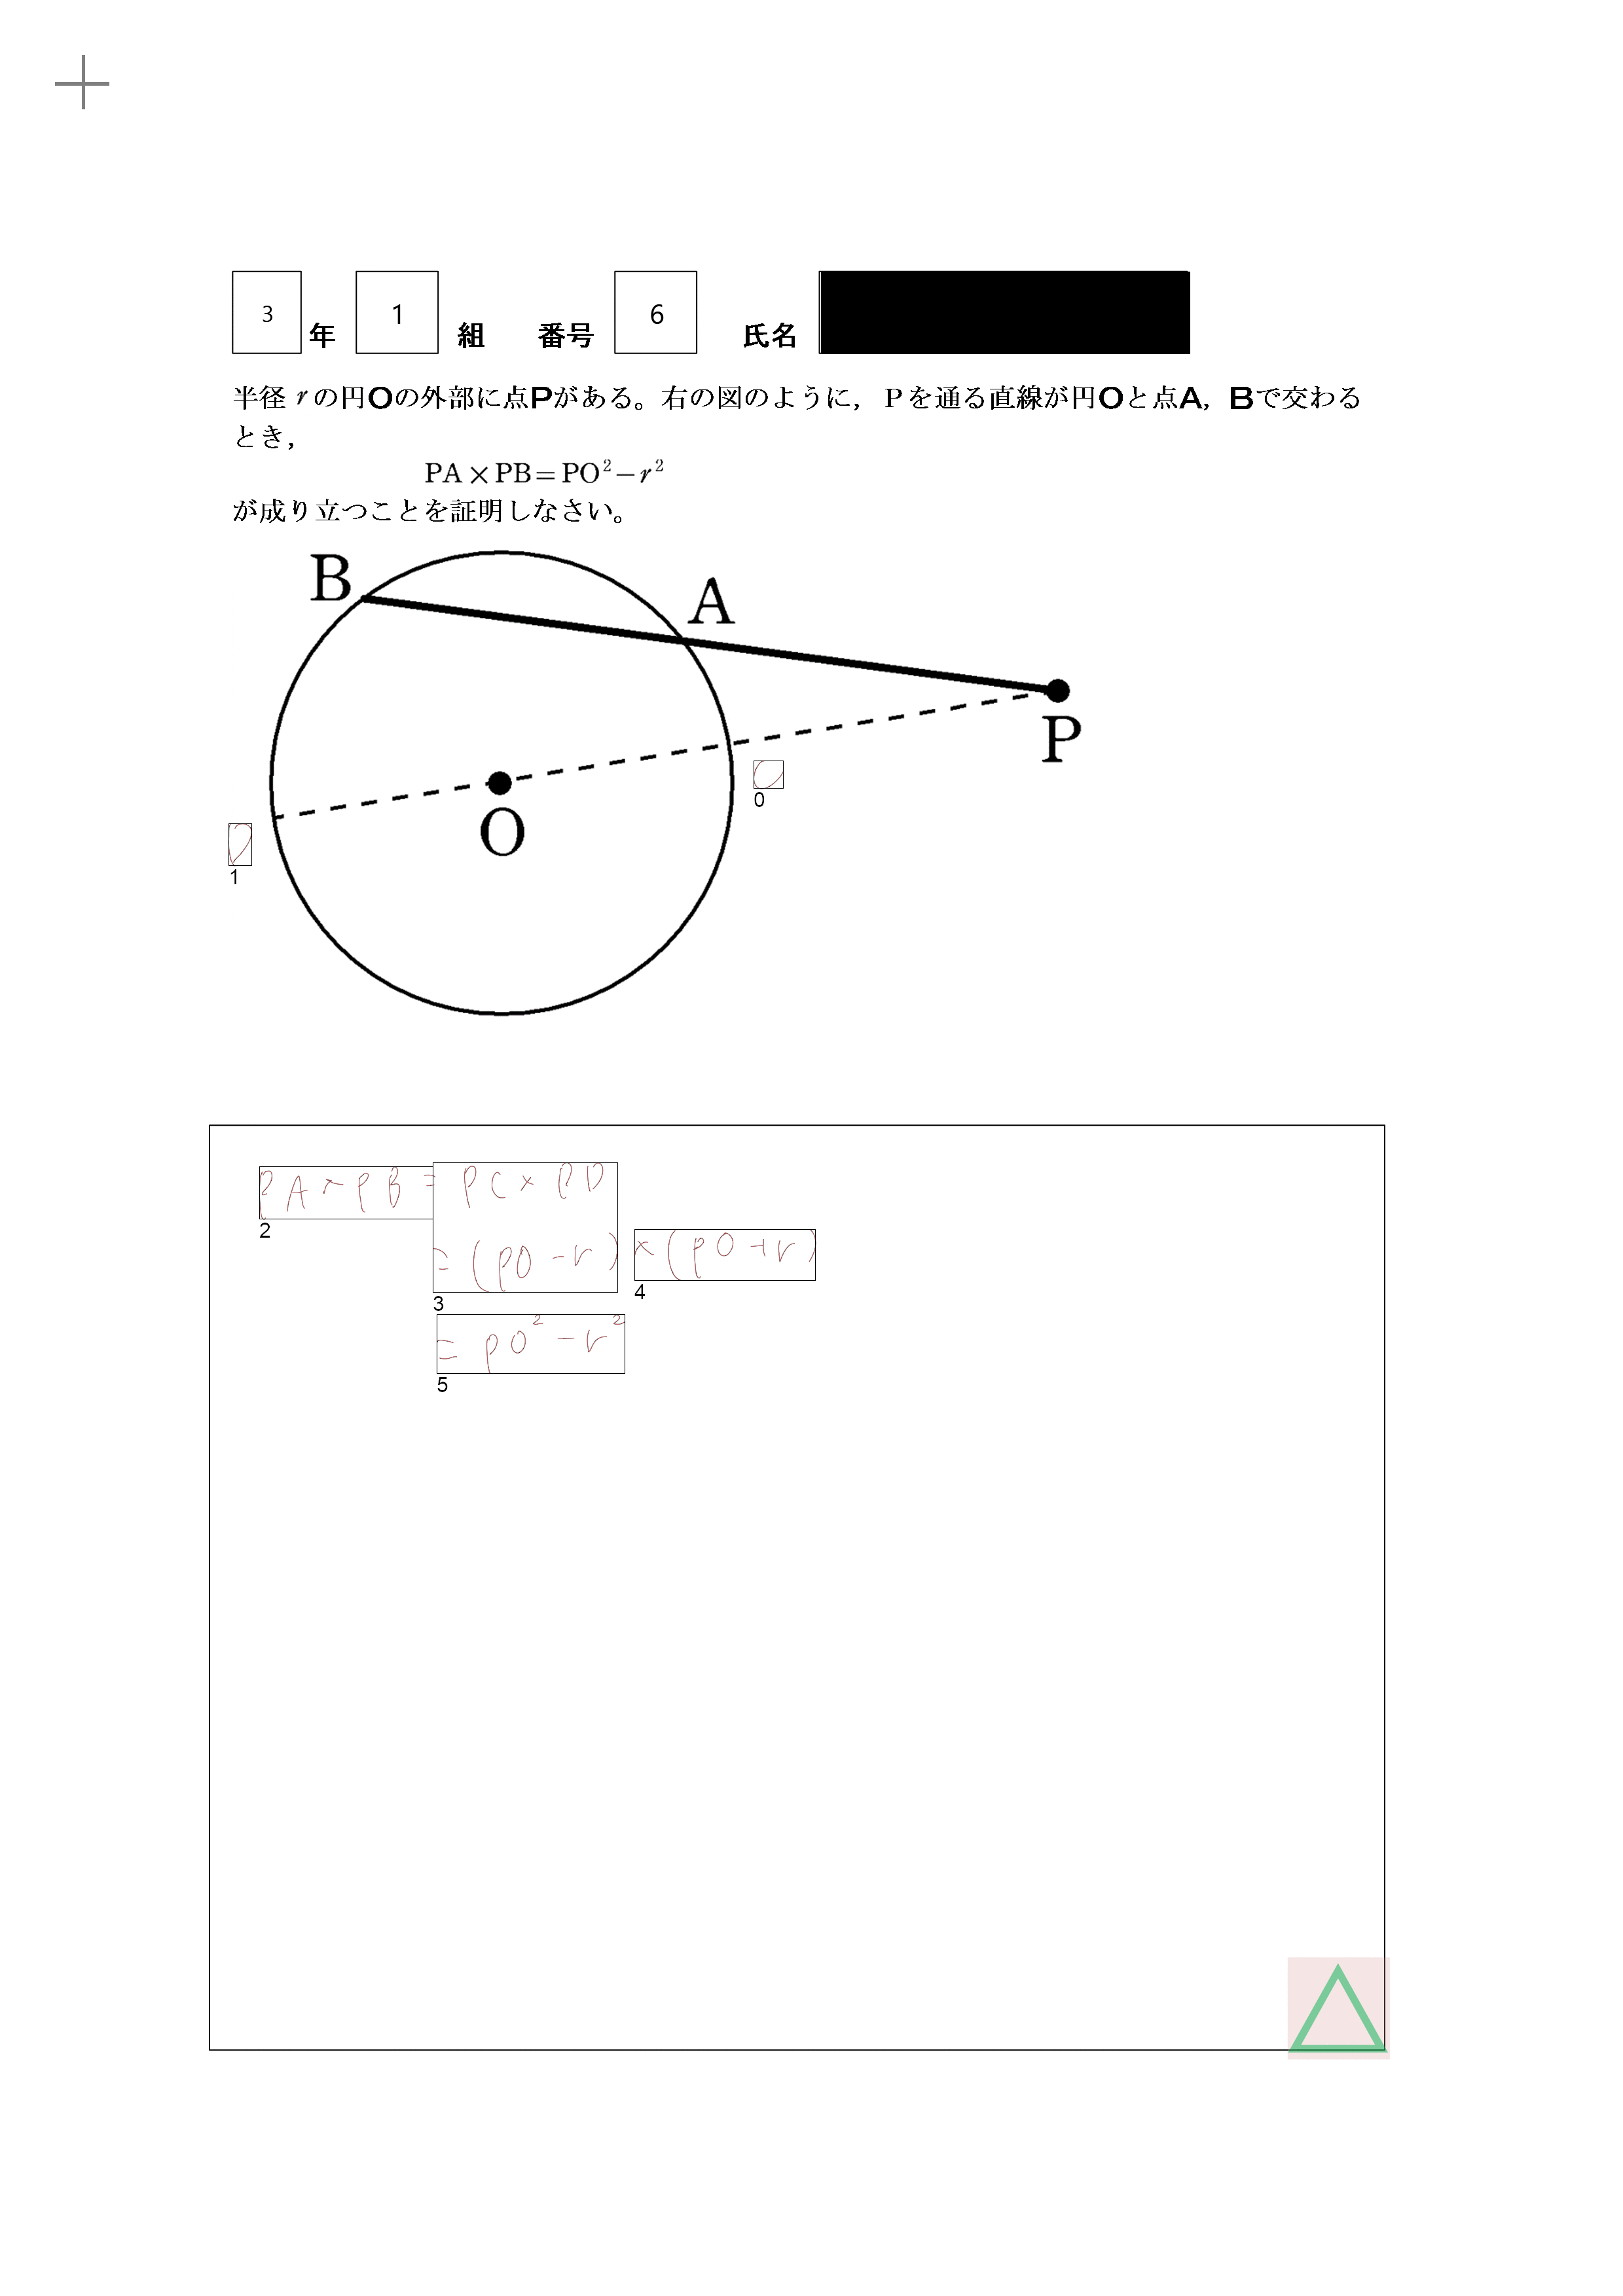

In [152]:

import PIL
imagename = "test/image" + filenum + ".gif"
image = PIL.Image.open(imagename)
overlayimage = abc.overlay_image(image)
overlayimage2 = abc.overlay_block_image(overlayimage)
overlayimage2


In [153]:

print(abc.block_center[1])
print(abc.block_center)


[  358.16586151  1289.20933977]
[array([ 1167.39285714,  1185.85714286]), array([  358.16586151,  1289.20933977]), array([  518.46981896,  1815.26929514]), array([  796.69073349,  1862.52522683]), array([ 1087.48502239,  1908.10961583]), array([  786.83793694,  2047.08468821])]


In [154]:

abc.get_feature_value()


/root/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:502: RuntimeWarning: divide by zero encountered in long_scalars
/root/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:502: RuntimeWarning: invalid value encountered in long_scalars


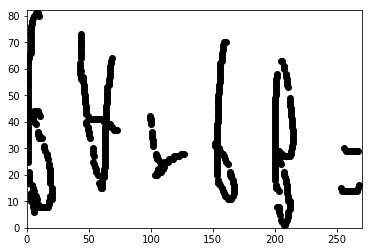

In [157]:
#print(abc.block_grid[1])
#print(abc.block_grid)
grid_plot(abc.block_grid[2])


In [ ]:

print(abc.block_grid[0][0])


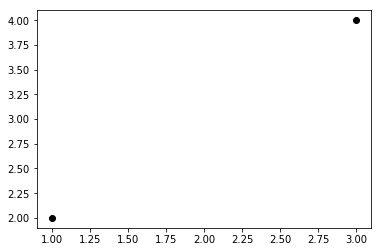

In [17]:

plt.plot(1,2,'o',color="k")
plt.plot(3,4,'o',color="k")
plt.show()


In [94]:
a = np.array([[0 for j in range(5)] for i in range(5)])


In [163]:
print(a[1][1])
a[1][1] = 5
a[2][3] = 1
print(a)

5
[[0 0 0 0 0]
 [0 5 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [164]:
print(a.nonzero())

(array([1, 2]), array([1, 3]))


In [175]:
def angle(x, y):

    dot_xy = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    cos = dot_xy / (norm_x*norm_y)
    rad = np.arccos(cos)
    theta = rad * 180 / np.pi

    return theta
a = np.array([1,0])
b = np.array([-1,0])
print(angle(a,b))

180.0
